# Stock investing Example

In [1]:
#%load_ext autoreload
#%autoreload 2
import numpy as np
import copy 
import random
import pandas as pd
import datetime as dt
from tqdm import tqdm
from scipy.stats import binom
import matplotlib.dates as mdates
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import yfinance as yf
import itertools
from finite_q_learning import *
from q_learning import *

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
rng = np.random.default_rng(SEED)

Importation of market data from yahoo finance

In [2]:
# 10 largest stocks by market cap as of Jan 2024
tickers = ["NVDA", "AAPL", "MSFT", "AMZN", "GOOGL","AVGO","JPM"]


data = [yf.download(t, start="2010-01-02", end="2026-01-01") for t in tickers]
data = [data[i].reset_index() for i in range(len(data))]
for i in range(len(data)):
    data[i]["Date"] =  data[i]['Date'].dt.normalize()
    data[i].set_index('Date', inplace=True)
    data[i] = data[i].reset_index()

C:\Users\jul_ses\AppData\Local\Temp\ipykernel_17072\2867603306.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = [yf.download(t, start="2010-01-02", end="2026-01-01") for t in tickers]
[*********************100%***********************]  1 of 1 completed
C:\Users\jul_ses\AppData\Local\Temp\ipykernel_17072\2867603306.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = [yf.download(t, start="2010-01-02", end="2026-01-01") for t in tickers]
[*********************100%***********************]  1 of 1 completed
C:\Users\jul_ses\AppData\Local\Temp\ipykernel_17072\2867603306.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = [yf.download(t, start="2010-01-02", end="2026-01-01") for t in tickers]
[*********************100%***********************]  1 of 1 completed
C:\Users\jul_ses\AppData\Local\Temp\ipykernel_17072\2867603306.py:5: FutureWarning: YF.download() has changed

Computation of the return of the stock selected

In [3]:
close_prices = [data[i]["Close"].values.flatten() for i in range(len(data))]  # Convert to 1D array
ind_pos = [((np.diff(close_prices[i]) / close_prices[i][:-1]) >= 0) for i in range(len(close_prices))]
ind_neg = [((np.diff(close_prices[i]) / close_prices[i][:-1]) < 0) for i in range(len(close_prices))]

returns =  [np.zeros(len(data[i])-1)   for i in range(len(data))]
for i in range(len(data)):
    returns[i][ind_pos[i]] = 1
    returns[i][ind_neg[i]] = -1

Definition of training and testing periods

In [4]:
def analyze_market_periods(signs, window=250):
    """
    Analyze a sequence of signed returns to find characteristic periods.

    Parameters
    ----------
    signs : array-like
        Sequence of signs of returns (e.g. -1, 0, 1 or just -1, 1).
    window : int, optional
        Size of the sliding window (default 250).

    Returns
    -------
    dict
        Dictionary with starting indices of:
        - most volatile period
        - most increasing period
        - most decreasing period
    """

    signs = np.asarray(signs)

    def calculate_volatility(window_signs):
        """
        Volatility proxy for signs: fraction of sign changes.
        """
        return np.mean(np.abs(np.diff(window_signs)))

    def calculate_trend(window_signs):
        """
        Trend proxy: cumulative signed return.
        """
        return np.sum(window_signs)

    max_volatility = -np.inf
    max_increase = -np.inf
    max_decrease = np.inf

    volatile_start = None
    increasing_start = None
    decreasing_start = None

    for start_idx in range(len(signs) - window + 1):
        end_idx = start_idx + window
        window_signs = signs[start_idx:end_idx]

        volatility = calculate_volatility(window_signs)
        trend = calculate_trend(window_signs)

        # Most volatile window
        if volatility > max_volatility:
            max_volatility = volatility
            volatile_start = start_idx

        # Most increasing window
        if trend > max_increase:
            max_increase = trend
            increasing_start = start_idx

        # Most decreasing window
        if trend < max_decrease:
            max_decrease = trend
            decreasing_start = start_idx

    return {
        "most_volatile_start": volatile_start,
        "most_increasing_start": increasing_start,
        "most_decreasing_start": decreasing_start
    }

In [5]:
start = 0
index_period_vol = []
index_period_increasing = []
index_period_decreasing = []
for i in range(len(tickers)):
    market_periods = analyze_market_periods(returns[i][start:3000], window=250)
    print(f"Ticker: {tickers[i]}")  
    print(f"Most volatile period starts at index: {market_periods['most_volatile_start'] + start}")
    print(f"Most increasing period starts at index: {market_periods['most_increasing_start'] + start}")
    print(f"Most decreasing period starts at index: {market_periods['most_decreasing_start'] + start}")
    index_period_vol.append(market_periods['most_volatile_start'] + start)
    index_period_increasing.append(market_periods['most_increasing_start'] + start)
    index_period_decreasing.append(market_periods['most_decreasing_start'] + start) 

Ticker: NVDA
Most volatile period starts at index: 2387
Most increasing period starts at index: 1420
Most decreasing period starts at index: 353
Ticker: AAPL
Most volatile period starts at index: 2511
Most increasing period starts at index: 2272
Most decreasing period starts at index: 1292
Ticker: MSFT
Most volatile period starts at index: 2508
Most increasing period starts at index: 1945
Most decreasing period starts at index: 507
Ticker: AMZN
Most volatile period starts at index: 1092
Most increasing period starts at index: 1951
Most decreasing period starts at index: 460
Ticker: GOOGL
Most volatile period starts at index: 2543
Most increasing period starts at index: 2695
Most decreasing period starts at index: 2047
Ticker: AVGO
Most volatile period starts at index: 907
Most increasing period starts at index: 723
Most decreasing period starts at index: 1287
Ticker: JPM
Most volatile period starts at index: 26
Most increasing period starts at index: 1099
Most decreasing period starts 

In [6]:
# Definition of training and testing periods
test_period_start1 = 3_001
test_period_end1 = 3_300

test_period_start2 = 3_301
test_period_end2 = 3_500

test_period_start3 = 3_500
test_period_end3 = 4000

# Create training and test sets for each ticker
returns_train_1  = [ret[index_period_vol[i]:index_period_vol[i]+250] for i, ret in enumerate(returns)]
returns_train_2  = [ret[index_period_increasing[i]:index_period_increasing[i]+250] for i, ret in enumerate(returns)]
returns_train_3  = [ret[index_period_decreasing[i]:index_period_decreasing[i]+250] for i, ret in enumerate(returns)]
returns_train_all = [ret[start:3000] for ret in returns]

returns_test_1 = [ret[test_period_start1:test_period_end1] for ret in returns]
returns_test_2 = [ret[test_period_start2:test_period_end2] for ret in returns]
returns_test_3 = [ret[test_period_start3:test_period_end3] for ret in returns]

Verification that the training periods correspond to really different periods

## Illustration of Training and Test Periods

Overall

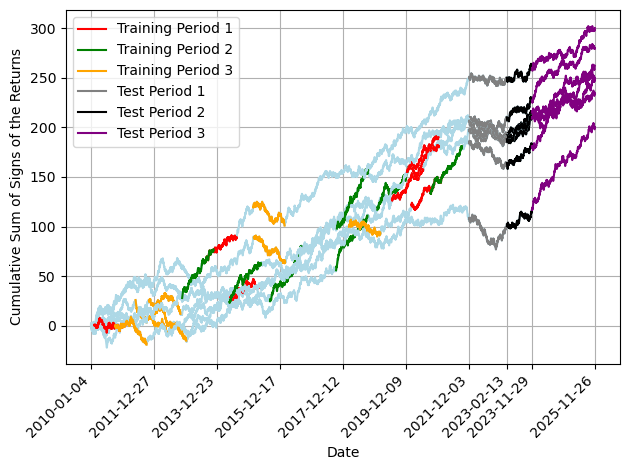

In [7]:
for i in range(len(tickers)):
    plt.plot(range(test_period_end2),returns[i][:test_period_end2].cumsum(),color = "lightblue")
    plt.plot(range(index_period_vol[i],index_period_vol[i]+250),returns[i].cumsum()[index_period_vol[i]:index_period_vol[i]+250],color = "red",label = "Training Period 1")
    plt.plot(range(index_period_increasing[i],index_period_increasing[i]+250),returns[i].cumsum()[index_period_increasing[i]:index_period_increasing[i]+250],color = "green",label = "Training Period 2")
    plt.plot(range(index_period_decreasing[i],index_period_decreasing[i]+250),returns[i].cumsum()[index_period_decreasing[i]:index_period_decreasing[i]+250],color = "orange",label = "Training Period 3")
    plt.plot(range(test_period_start1,test_period_end1),returns[i].cumsum()[test_period_start1:test_period_end1],color = "gray",label = "Test Period 1")
    plt.plot(range(test_period_start2,test_period_end2),returns[i].cumsum()[test_period_start2:test_period_end2],color = "black",label = "Test Period 2")
    plt.plot(range(test_period_start3,test_period_end3),returns[i].cumsum()[test_period_start3:test_period_end3],color = "purple",label = "Test Period 3")

plt.ylabel("Cumulative Sum of Signs of the Returns")
plt.xlabel("Date")
# xtick_numbers = [0,test_period_start1]
# plt.xticks(xtick_numbers, data["Date"].iloc[xtick_numbers])

# Customize x-axis to show only the day and year
date_format = mdates.DateFormatter('%d-%Y')
plt.gca().xaxis.set_major_formatter(date_format)

# Set the locations of the ticks on x-axis
xtick_numbers = [0,500,1000,1500,2000,2500,
                 test_period_start1,test_period_end1,test_period_end2,test_period_end3]
plt.xticks(xtick_numbers,data[0]["Date"].dt.date[xtick_numbers], rotation=45,ha = "right")

handles, labels = plt.gca().get_legend_handles_labels()
unique = dict(zip(labels, handles))
plt.legend(unique.values(), unique.keys(), loc="best")

#plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('portfolio_train_test.pdf', format='pdf')
plt.show()

In [8]:
h    = 3 # Length of history
ret1 = returns_train_1
ret2 = returns_train_2
ret3 = returns_train_3
ret_all = returns_train_all

Definition of the parameters to use the algorithm

In [9]:
# Action Space
A = np.array([-1, 0,1]) 


# State Space (return history + last action)
T = [-1, 1]
X = np.array([
    np.concatenate([np.array(x), [a]])
    for x, a in itertools.product(itertools.product(T, repeat=h), A)
])


In [10]:
def r(x, a, y):
    # y[-2] is the most recent return; y[-1] is the last action
    return a * y[-2]- 0.1 * abs(a - y[-1])

rng = np.random.default_rng()
x1_0 = [
    np.concatenate([
        rng.choice(np.array([ret1[j][i:(h+i)] for i in range(len(ret1[j]) - h - 1)]), axis=0),
        [0]
    ])
    for j in range(len(ret1))
]
x2_0 = [
    np.concatenate([
        rng.choice(np.array([ret2[j][i:(h+i)] for i in range(len(ret2[j]) - h - 1)]), axis=0),
        [0]
    ])
    for j in range(len(ret2))
]
x3_0 = [
    np.concatenate([
        rng.choice(np.array([ret3[j][i:(h+i)] for i in range(len(ret3[j]) - h - 1)]), axis=0),
        [0]
    ])
    for j in range(len(ret3))
]
x_all_0 = [
    np.concatenate([
        rng.choice(np.array([ret_all[j][i:(h+i)] for i in range(len(ret_all[j]) - h - 1)]), axis=0),
        [0]
    ])
    for j in range(len(ret_all))
]

k_0 = 0

In [11]:
# Build the functions that allow us to get the index of an element a (reps. x) in A (resp. X)
if np.ndim(A) > 1:
    A_list = A
else:
    A_list = np.array([[a] for a in A])
if np.ndim(X) > 1:
    X_list = X
else:
    X_list = np.array([[x] for x in X])

def a_index(a):
    return np.flatnonzero((a==A_list).all(1))[0]
def x_index(x):
    return np.flatnonzero((x==X_list).all(1))[0]

Construction of the scenario generators

In [12]:
P1_list = []
P2_list = []
P3_list = []
P_all_list = [] 

for i in range(len(tickers)):
    # Pre-compute all possible h-length sequences for this ticker (returns only)
    ret1_sequences = np.array([ret1[i][j:(h+j)] for j in range(len(ret1[i]) - h)])
    ret2_sequences = np.array([ret2[i][j:(h+j)] for j in range(len(ret2[i]) - h)])
    ret3_sequences = np.array([ret3[i][j:(h+j)] for j in range(len(ret3[i]) - h)])
    ret_all_sequences = np.array([ret_all[i][j:(h+j)] for j in range(len(ret_all[i]) - h)])

    # Pre-compute next values (shifted by 1)
    ret1_next = ret1[i][h:]
    ret2_next = ret2[i][h:]
    ret3_next = ret3[i][h:]
    ret_all_next = ret_all[i][h:]

    def P1(x, a):
        matches = np.all(ret1_sequences == x[:-1], axis=1)
        if np.any(matches):
            rand = rng.choice(ret1_next[matches])
        else:
            rand = rng.choice(T)
        return np.concatenate([x[1:-1], [rand], [a]])
    P1_list.append(P1)

    def P2(x, a):
        matches = np.all(ret2_sequences == x[:-1], axis=1)
        if np.any(matches):
            rand = rng.choice(ret2_next[matches])
        else:
            rand = rng.choice(T)
        return np.concatenate([x[1:-1], [rand], [a]])
    P2_list.append(P2)

    def P3(x, a):
        matches = np.all(ret3_sequences == x[:-1], axis=1)
        if np.any(matches):
            rand = rng.choice(ret3_next[matches])
        else:
            rand = rng.choice(T)
        return np.concatenate([x[1:-1], [rand], [a]])
    P3_list.append(P3)

    def P_all(x, a):
        matches = np.all(ret_all_sequences == x[:-1], axis=1)
        if np.any(matches):
            rand = rng.choice(ret_all_next[matches])
        else:
            rand = rng.choice(T)
        return np.concatenate([x[1:-1], [rand], [a]])
    P_all_list.append(P_all)

Define a function to evaluate the optimal action

In [13]:
def a_opt(t, Q_opt):
    return A[np.argmax(Q_opt[x_index(t),:])]

Compute the optimal Q-Value Functions

In [14]:
Nr_iter = 1000000
epsilon_greedy = lambda t: np.max([0.05, 1-2*t/Nr_iter])
alpha      = 0.95  # Discount Factor
gamma_t_tilde = lambda t: 1/(t+1)**(0.6)

Q_opt_robust_1 = []
Q_opt_1 = []
Q_opt_2 = []
Q_opt_3 = []        
Q_opt_all = []
for i in range(len(tickers)):
    Q_opt_robust_1.append(finite_q_learning(X, A, r, np.array([P_all_list[i],P1_list[i], P2_list[i], P3_list[i]]), alpha, x1_0[i], k_0, epsilon_greedy, Nr_iter, gamma_t_tilde, Q_0 = np.zeros([len(X),len(A)]))[0])
    Q_opt_1.append(finite_q_learning(X, A, r, [P1_list[i]], alpha, x1_0[i], 0,epsilon_greedy, Nr_iter, gamma_t_tilde, Q_0 = np.zeros([len(X),len(A)]))[0])
    Q_opt_2.append(finite_q_learning(X, A, r, [P2_list[i]], alpha, x2_0[i], 0, epsilon_greedy, Nr_iter, gamma_t_tilde , Q_0 = np.zeros([len(X),len(A)]))[0])
    Q_opt_3.append(finite_q_learning(X, A, r, [P3_list[i]], alpha, x3_0[i], 0, epsilon_greedy, Nr_iter, gamma_t_tilde , Q_0 = np.zeros([len(X),len(A)]))[0])
    Q_opt_all.append(finite_q_learning(X, A, r, [P_all_list[i]], alpha, x_all_0[i], 0, epsilon_greedy, Nr_iter, gamma_t_tilde , Q_0 = np.zeros([len(X),len(A)]))[0])
    


100%|██████████| 1000000/1000000 [05:45<00:00, 2896.70it/s]


# Evaluation

In [15]:
def evaluate_strategies(returns_list):
    """
    Evaluate strategies across all tickers
    
    Parameters:
    returns_list: list of return arrays, one for each ticker
    """
    n_tickers = len(returns_list)
    
    all_robust_rewards = []
    all_rewards_1 = []
    all_rewards_2 = []
    all_rewards_3 = []
    all_rewards_all = []
    all_trend_following = []
    all_buy_and_hold = []
    
    ticker_avg_robust = []
    ticker_avg_1 = []
    ticker_avg_2 = []
    ticker_avg_3 = []
    ticker_avg_all = []
    ticker_avg_trend = []
    ticker_avg_buy = []
    
    total_days = 0
    total_negative = 0
    total_positive = 0

    def simulate_rewards(returns, Q_opt):
        a_prev = 0
        rewards = []
        for j in range(len(returns) - h - 1):
            x = np.concatenate([returns[j:(h + j)], [a_prev]])
            a = a_opt(x, Q_opt)
            y = np.concatenate([returns[j + 1:(h + j + 1)], [a]])
            rewards.append(r(x, a, y))
            a_prev = a
        return np.array(rewards)
    
    for i, returns in enumerate(returns_list):
        total_days += len(returns)
        total_negative += np.sum(returns == -1)
        total_positive += np.sum(returns == 1)
        
        robust_rewards = simulate_rewards(returns, Q_opt_robust_1[i])
        rewards_1 = simulate_rewards(returns, Q_opt_1[i])
        rewards_2 = simulate_rewards(returns, Q_opt_2[i])
        rewards_3 = simulate_rewards(returns, Q_opt_3[i])
        rewards_all = simulate_rewards(returns, Q_opt_all[i])
        
        trend_following = np.array([
            ((returns[j + h - 1] - returns[j] > 0)) * returns[j + h]
            for j in range(len(returns) - h - 1)
        ])
        buy_and_hold = np.array([
            returns[j + h]
            for j in range(len(returns) - h - 1)
        ])
        
        all_robust_rewards.extend(robust_rewards)
        all_rewards_1.extend(rewards_1)
        all_rewards_2.extend(rewards_2)
        all_rewards_3.extend(rewards_3)
        all_rewards_all.extend(rewards_all)
        all_trend_following.extend(trend_following)
        all_buy_and_hold.extend(buy_and_hold)
        
        ticker_avg_robust.append(np.mean(robust_rewards))
        ticker_avg_1.append(np.mean(rewards_1))
        ticker_avg_2.append(np.mean(rewards_2))
        ticker_avg_3.append(np.mean(rewards_3))
        ticker_avg_all.append(np.mean(rewards_all))
        ticker_avg_trend.append(np.mean(trend_following))
        ticker_avg_buy.append(np.mean(buy_and_hold))
    
    # Print aggregate statistics
    print(f"Total Tickers:    {n_tickers}")
    print(f"Avg Days/Ticker:  {total_days/n_tickers:.0f}")
    print(f"Negative Returns: {total_negative}")
    print(f"Positive Returns: {total_positive}\n")
    
    print(
            "- Average Profit per Trade (All Tickers) -\n"
            f"Robust:          {np.mean(all_robust_rewards):0.4f}\n"
            f"Non-Robust 1:    {np.mean(all_rewards_1):0.4f}\n"
            f"Non-Robust 2:    {np.mean(all_rewards_2):0.4f}\n"
            f"Non-Robust 3:    {np.mean(all_rewards_3):0.4f}\n"
            f"All Data:        {np.mean(all_rewards_all):0.4f}\n"
            f"Trend following: {np.mean(all_trend_following):0.4f}\n"
            f"Buy and hold:    {np.mean(all_buy_and_hold):0.4f}"
        )
    
    # Min/Max avg return across all tickers (single summary)
    ticker_arr = np.array(tickers)
    def min_max_ticker(vals):
        vals = np.array(vals)
        return ticker_arr[np.argmin(vals)], np.min(vals), ticker_arr[np.argmax(vals)], np.max(vals)

    r_min_t, r_min_v, r_max_t, r_max_v = min_max_ticker(ticker_avg_robust)
    n1_min_t, n1_min_v, n1_max_t, n1_max_v = min_max_ticker(ticker_avg_1)
    n2_min_t, n2_min_v, n2_max_t, n2_max_v = min_max_ticker(ticker_avg_2)
    n3_min_t, n3_min_v, n3_max_t, n3_max_v = min_max_ticker(ticker_avg_3)
    a_min_t, a_min_v, a_max_t, a_max_v = min_max_ticker(ticker_avg_all)
    t_min_t, t_min_v, t_max_t, t_max_v = min_max_ticker(ticker_avg_trend)
    b_min_t, b_min_v, b_max_t, b_max_v = min_max_ticker(ticker_avg_buy)

    print(
        "\n- Min/Max Avg Return (Across All Tickers) -\n"
        f"Robust:          min {r_min_t} ({r_min_v:0.4f}), max {r_max_t} ({r_max_v:0.4f})\n"
        f"Non-Robust 1:    min {n1_min_t} ({n1_min_v:0.4f}), max {n1_max_t} ({n1_max_v:0.4f})\n"
        f"Non-Robust 2:    min {n2_min_t} ({n2_min_v:0.4f}), max {n2_max_t} ({n2_max_v:0.4f})\n"
        f"Non-Robust 3:    min {n3_min_t} ({n3_min_v:0.4f}), max {n3_max_t} ({n3_max_v:0.4f})\n"
        f"All Data:        min {a_min_t} ({a_min_v:0.4f}), max {a_max_t} ({a_max_v:0.4f})\n"
        f"Trend following: min {t_min_t} ({t_min_v:0.4f}), max {t_max_t} ({t_max_v:0.4f})\n"
        f"Buy and hold:    min {b_min_t} ({b_min_v:0.4f}), max {b_max_t} ({b_max_v:0.4f})"
    )
        
    # Optionally, print per-ticker breakdown
    print("\n- Per-Ticker Breakdown -")
    for i in range(n_tickers):
        ticker_indices = slice(i * (len(all_robust_rewards)//n_tickers), 
                                (i+1) * (len(all_robust_rewards)//n_tickers))
        print(f"\n{tickers[i]}:")
        print(f"  Robust:       {np.mean(all_robust_rewards[ticker_indices]):0.4f}")
        print(f"  Non-Robust 1: {np.mean(all_rewards_1[ticker_indices]):0.4f}")
        print(f"  Non-Robust 2: {np.mean(all_rewards_2[ticker_indices]):0.4f}")
        print(f"  Non-Robust 3: {np.mean(all_rewards_3[ticker_indices]):0.4f}")


### First Training Period

In [16]:
evaluate_strategies(returns_train_1)

Total Tickers:    7
Avg Days/Ticker:  250
Negative Returns: 795
Positive Returns: 955

- Average Profit per Trade (All Tickers) -
Robust:          0.0221
Non-Robust 1:    0.1458
Non-Robust 2:    0.1022
Non-Robust 3:    -0.0581
All Data:        0.1429
Trend following: -0.0285
Buy and hold:    0.0883

- Min/Max Avg Return (Across All Tickers) -
Robust:          min AVGO (0.0163), max AAPL (0.0285)
Non-Robust 1:    min AMZN (0.0894), max AVGO (0.2033)
Non-Robust 2:    min JPM (-0.0081), max MSFT (0.1748)
Non-Robust 3:    min MSFT (-0.1341), max JPM (0.0488)
All Data:        min JPM (0.1057), max MSFT (0.2073)
Trend following: min AMZN (-0.0691), max GOOGL (-0.0081)
Buy and hold:    min JPM (0.0000), max MSFT (0.1382)

- Per-Ticker Breakdown -

NVDA:
  Robust:       0.0244
  Non-Robust 1: 0.1585
  Non-Robust 2: 0.1220
  Non-Robust 3: -0.0528

AAPL:
  Robust:       0.0285
  Non-Robust 1: 0.1545
  Non-Robust 2: 0.1098
  Non-Robust 3: -0.0569

MSFT:
  Robust:       0.0203
  Non-Robust 1: 0.12

### Second Training Period

In [17]:
evaluate_strategies(returns_train_2)

Total Tickers:    7
Avg Days/Ticker:  250
Negative Returns: 700
Positive Returns: 1050

- Average Profit per Trade (All Tickers) -
Robust:          0.0244
Non-Robust 1:    0.0691
Non-Robust 2:    0.1725
Non-Robust 3:    -0.1312
All Data:        0.0964
Trend following: 0.0407
Buy and hold:    0.1916

- Min/Max Avg Return (Across All Tickers) -
Robust:          min JPM (0.0081), max AMZN (0.0407)
Non-Robust 1:    min AMZN (-0.0081), max MSFT (0.1220)
Non-Robust 2:    min AAPL (0.1179), max MSFT (0.2114)
Non-Robust 3:    min NVDA (-0.1829), max AAPL (-0.0569)
All Data:        min AMZN (0.0407), max MSFT (0.1504)
Trend following: min JPM (0.0041), max AMZN (0.0732)
Buy and hold:    min JPM (0.1545), max AMZN (0.2276)

- Per-Ticker Breakdown -

NVDA:
  Robust:       0.0122
  Non-Robust 1: 0.0407
  Non-Robust 2: 0.1911
  Non-Robust 3: -0.1829

AAPL:
  Robust:       0.0366
  Non-Robust 1: 0.0569
  Non-Robust 2: 0.1179
  Non-Robust 3: -0.0569

MSFT:
  Robust:       0.0163
  Non-Robust 1: 0.122

### Third Training Period

In [18]:
evaluate_strategies(returns_train_3)

Total Tickers:    7
Avg Days/Ticker:  250
Negative Returns: 948
Positive Returns: 802

- Average Profit per Trade (All Tickers) -
Robust:          0.0046
Non-Robust 1:    0.0134
Non-Robust 2:    -0.0668
Non-Robust 3:    0.0772
All Data:        -0.0081
Trend following: -0.0267
Buy and hold:    -0.0790

- Min/Max Avg Return (Across All Tickers) -
Robust:          min NVDA (-0.0285), max JPM (0.0407)
Non-Robust 1:    min AVGO (-0.0691), max AMZN (0.0772)
Non-Robust 2:    min NVDA (-0.1260), max AVGO (-0.0285)
Non-Robust 3:    min AVGO (-0.0203), max JPM (0.1463)
All Data:        min NVDA (-0.0447), max AMZN (0.0325)
Trend following: min AAPL (-0.0772), max GOOGL (0.0325)
Buy and hold:    min NVDA (-0.1220), max GOOGL (-0.0325)

- Per-Ticker Breakdown -

NVDA:
  Robust:       -0.0285
  Non-Robust 1: 0.0122
  Non-Robust 2: -0.1260
  Non-Robust 3: 0.0854

AAPL:
  Robust:       0.0203
  Non-Robust 1: 0.0081
  Non-Robust 2: -0.0447
  Non-Robust 3: 0.0894

MSFT:
  Robust:       -0.0041
  Non-Ro

# Test Period

### Test Period 1

In [19]:
evaluate_strategies(returns_test_1)

Total Tickers:    7
Avg Days/Ticker:  299
Negative Returns: 1078
Positive Returns: 1015

- Average Profit per Trade (All Tickers) -
Robust:          0.0005
Non-Robust 1:    -0.0460
Non-Robust 2:    -0.0436
Non-Robust 3:    0.0368
All Data:        -0.0397
Trend following: 0.0029
Buy and hold:    -0.0392

- Min/Max Avg Return (Across All Tickers) -
Robust:          min AVGO (-0.0203), max GOOGL (0.0203)
Non-Robust 1:    min NVDA (-0.0915), max AAPL (0.0203)
Non-Robust 2:    min GOOGL (-0.0847), max JPM (-0.0034)
Non-Robust 3:    min AVGO (-0.0339), max GOOGL (0.1254)
All Data:        min NVDA (-0.0949), max AVGO (0.0102)
Trend following: min AAPL (-0.0237), max NVDA (0.0305)
Buy and hold:    min GOOGL (-0.0847), max NVDA (0.0034)

- Per-Ticker Breakdown -

NVDA:
  Robust:       0.0102
  Non-Robust 1: -0.0915
  Non-Robust 2: -0.0237
  Non-Robust 3: 0.0102

AAPL:
  Robust:       0.0136
  Non-Robust 1: 0.0203
  Non-Robust 2: -0.0169
  Non-Robust 3: 0.0475

MSFT:
  Robust:       0.0034
  Non

### Test Period 2

In [20]:
evaluate_strategies(returns_test_2)

Total Tickers:    7
Avg Days/Ticker:  199
Negative Returns: 635
Positive Returns: 758

- Average Profit per Trade (All Tickers) -
Robust:          0.0168
Non-Robust 1:    0.0645
Non-Robust 2:    0.0733
Non-Robust 3:    -0.0462
All Data:        0.0469
Trend following: 0.0410
Buy and hold:    0.0989

- Min/Max Avg Return (Across All Tickers) -
Robust:          min AMZN (0.0000), max NVDA (0.0359)
Non-Robust 1:    min GOOGL (0.0205), max AMZN (0.1026)
Non-Robust 2:    min NVDA (0.0410), max AMZN (0.1385)
Non-Robust 3:    min AMZN (-0.1385), max NVDA (0.0000)
All Data:        min NVDA (-0.0051), max AMZN (0.1179)
Trend following: min JPM (0.0000), max AAPL (0.0769)
Buy and hold:    min AVGO (0.0667), max AMZN (0.1282)

- Per-Ticker Breakdown -

NVDA:
  Robust:       0.0359
  Non-Robust 1: 0.0615
  Non-Robust 2: 0.0410
  Non-Robust 3: 0.0000

AAPL:
  Robust:       0.0103
  Non-Robust 1: 0.0718
  Non-Robust 2: 0.0462
  Non-Robust 3: -0.0359

MSFT:
  Robust:       0.0051
  Non-Robust 1: 0.061

In [21]:
evaluate_strategies(returns_test_3)

Total Tickers:    7
Avg Days/Ticker:  500
Negative Returns: 1573
Positive Returns: 1927

- Average Profit per Trade (All Tickers) -
Robust:          0.0069
Non-Robust 1:    0.0150
Non-Robust 2:    0.0901
Non-Robust 3:    -0.0827
All Data:        0.0559
Trend following: 0.0389
Buy and hold:    0.1025

- Min/Max Avg Return (Across All Tickers) -
Robust:          min AAPL (-0.0202), max NVDA (0.0242)
Non-Robust 1:    min AAPL (-0.0464), max NVDA (0.0645)
Non-Robust 2:    min AVGO (0.0242), max JPM (0.1310)
Non-Robust 3:    min JPM (-0.1290), max AMZN (-0.0242)
All Data:        min AMZN (0.0141), max NVDA (0.1351)
Trend following: min AMZN (0.0040), max JPM (0.0706)
Buy and hold:    min AMZN (0.0524), max JPM (0.1613)

- Per-Ticker Breakdown -

NVDA:
  Robust:       0.0242
  Non-Robust 1: 0.0645
  Non-Robust 2: 0.1028
  Non-Robust 3: -0.0685

AAPL:
  Robust:       -0.0202
  Non-Robust 1: -0.0464
  Non-Robust 2: 0.0968
  Non-Robust 3: -0.1230

MSFT:
  Robust:       -0.0040
  Non-Robust 1: -